In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import sys
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, LogisticRegression

In [3]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings

In [24]:
with open('/home/akumar/nse/neural_control/na_decoding_df.dat', 'rb') as f:
    dat = pickle.load(f)
sabes_df = pd.DataFrame(dat)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
dimreduc_args = {'T':3, 'loss_type':'trace', 'n_init':10, 'normalize_reverse':False}
decoding_args = {'trainlag': 4, 'testlag': 4, 'decoding_window':5}

In [26]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

# PCA results for indy should be taken from an older dataframe because indy_decoding_df2 
# erroneously did not restrict the PCA dimension prior to doing decoding
# Grab PCA results
with open('/mnt/Secondary/data/postprocessed/sabes_kca_decodign_df.dat', 'rb') as f:
    pca_decoding_df = pickle.load(f)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 2, 'testlag': 2, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
    'loco_20170213_02.mat',
    'loco_20170215_02.mat',
    'loco_20170227_04.mat',
    'loco_20170228_02.mat',
    'loco_20170301_05.mat',
    'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        

indy_data_files = np.unique(indy_df['data_file'].values)
loco_data_files = np.unique(loco_df['data_file'].values)


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [27]:
indy_loco_df = pd.concat([indy_df, loco_df])

In [28]:
sabes_df_ = apply_df_filters(sabes_df, dimreduc_args=dimreduc_args, decoder_args=decoding_args)

In [29]:
data_files = np.unique(sabes_df_['data_file'].values)
dims = np.unique(sabes_df_['dim'].values)

r2 = np.zeros((len(data_files), dims.size, 5, 3))
r2fc = np.zeros((len(data_files), dims.size, 5, 3))
sr2_vel_pca = np.zeros((len(data_files), dims.size, 5, 3))

for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):
        for fold_idx in range(5):
            dim_df = apply_df_filters(sabes_df_, data_file=data_file, dim=dim, fold_idx=fold_idx)
            assert(dim_df.shape[0] == 1)
            r2[i, j, fold_idx, :] = dim_df.iloc[0]['r2']

for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(indy_loco_df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='LQGCA', )
            # Trace loss
            try:
                assert(dim_fold_df.shape[0] == 1)
            except:
                pdb.set_trace()
            r2fc[i, j, f, :] = dim_fold_df.iloc[0]['r2']

dims = np.unique(sabes_df['dim'].values)
for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dims):
        data_file = data_file.split('/')[-1]
        pca_df = apply_df_filters(pca_decoding_df, dim=dim, data_file=data_file, dr_method='PCA')        
        for k in range(pca_df.shape[0]):
            sr2_vel_pca[i, j, k] = pca_df.iloc[k]['r2'][1]

35it [00:04,  8.16it/s]
35it [00:10,  3.38it/s]


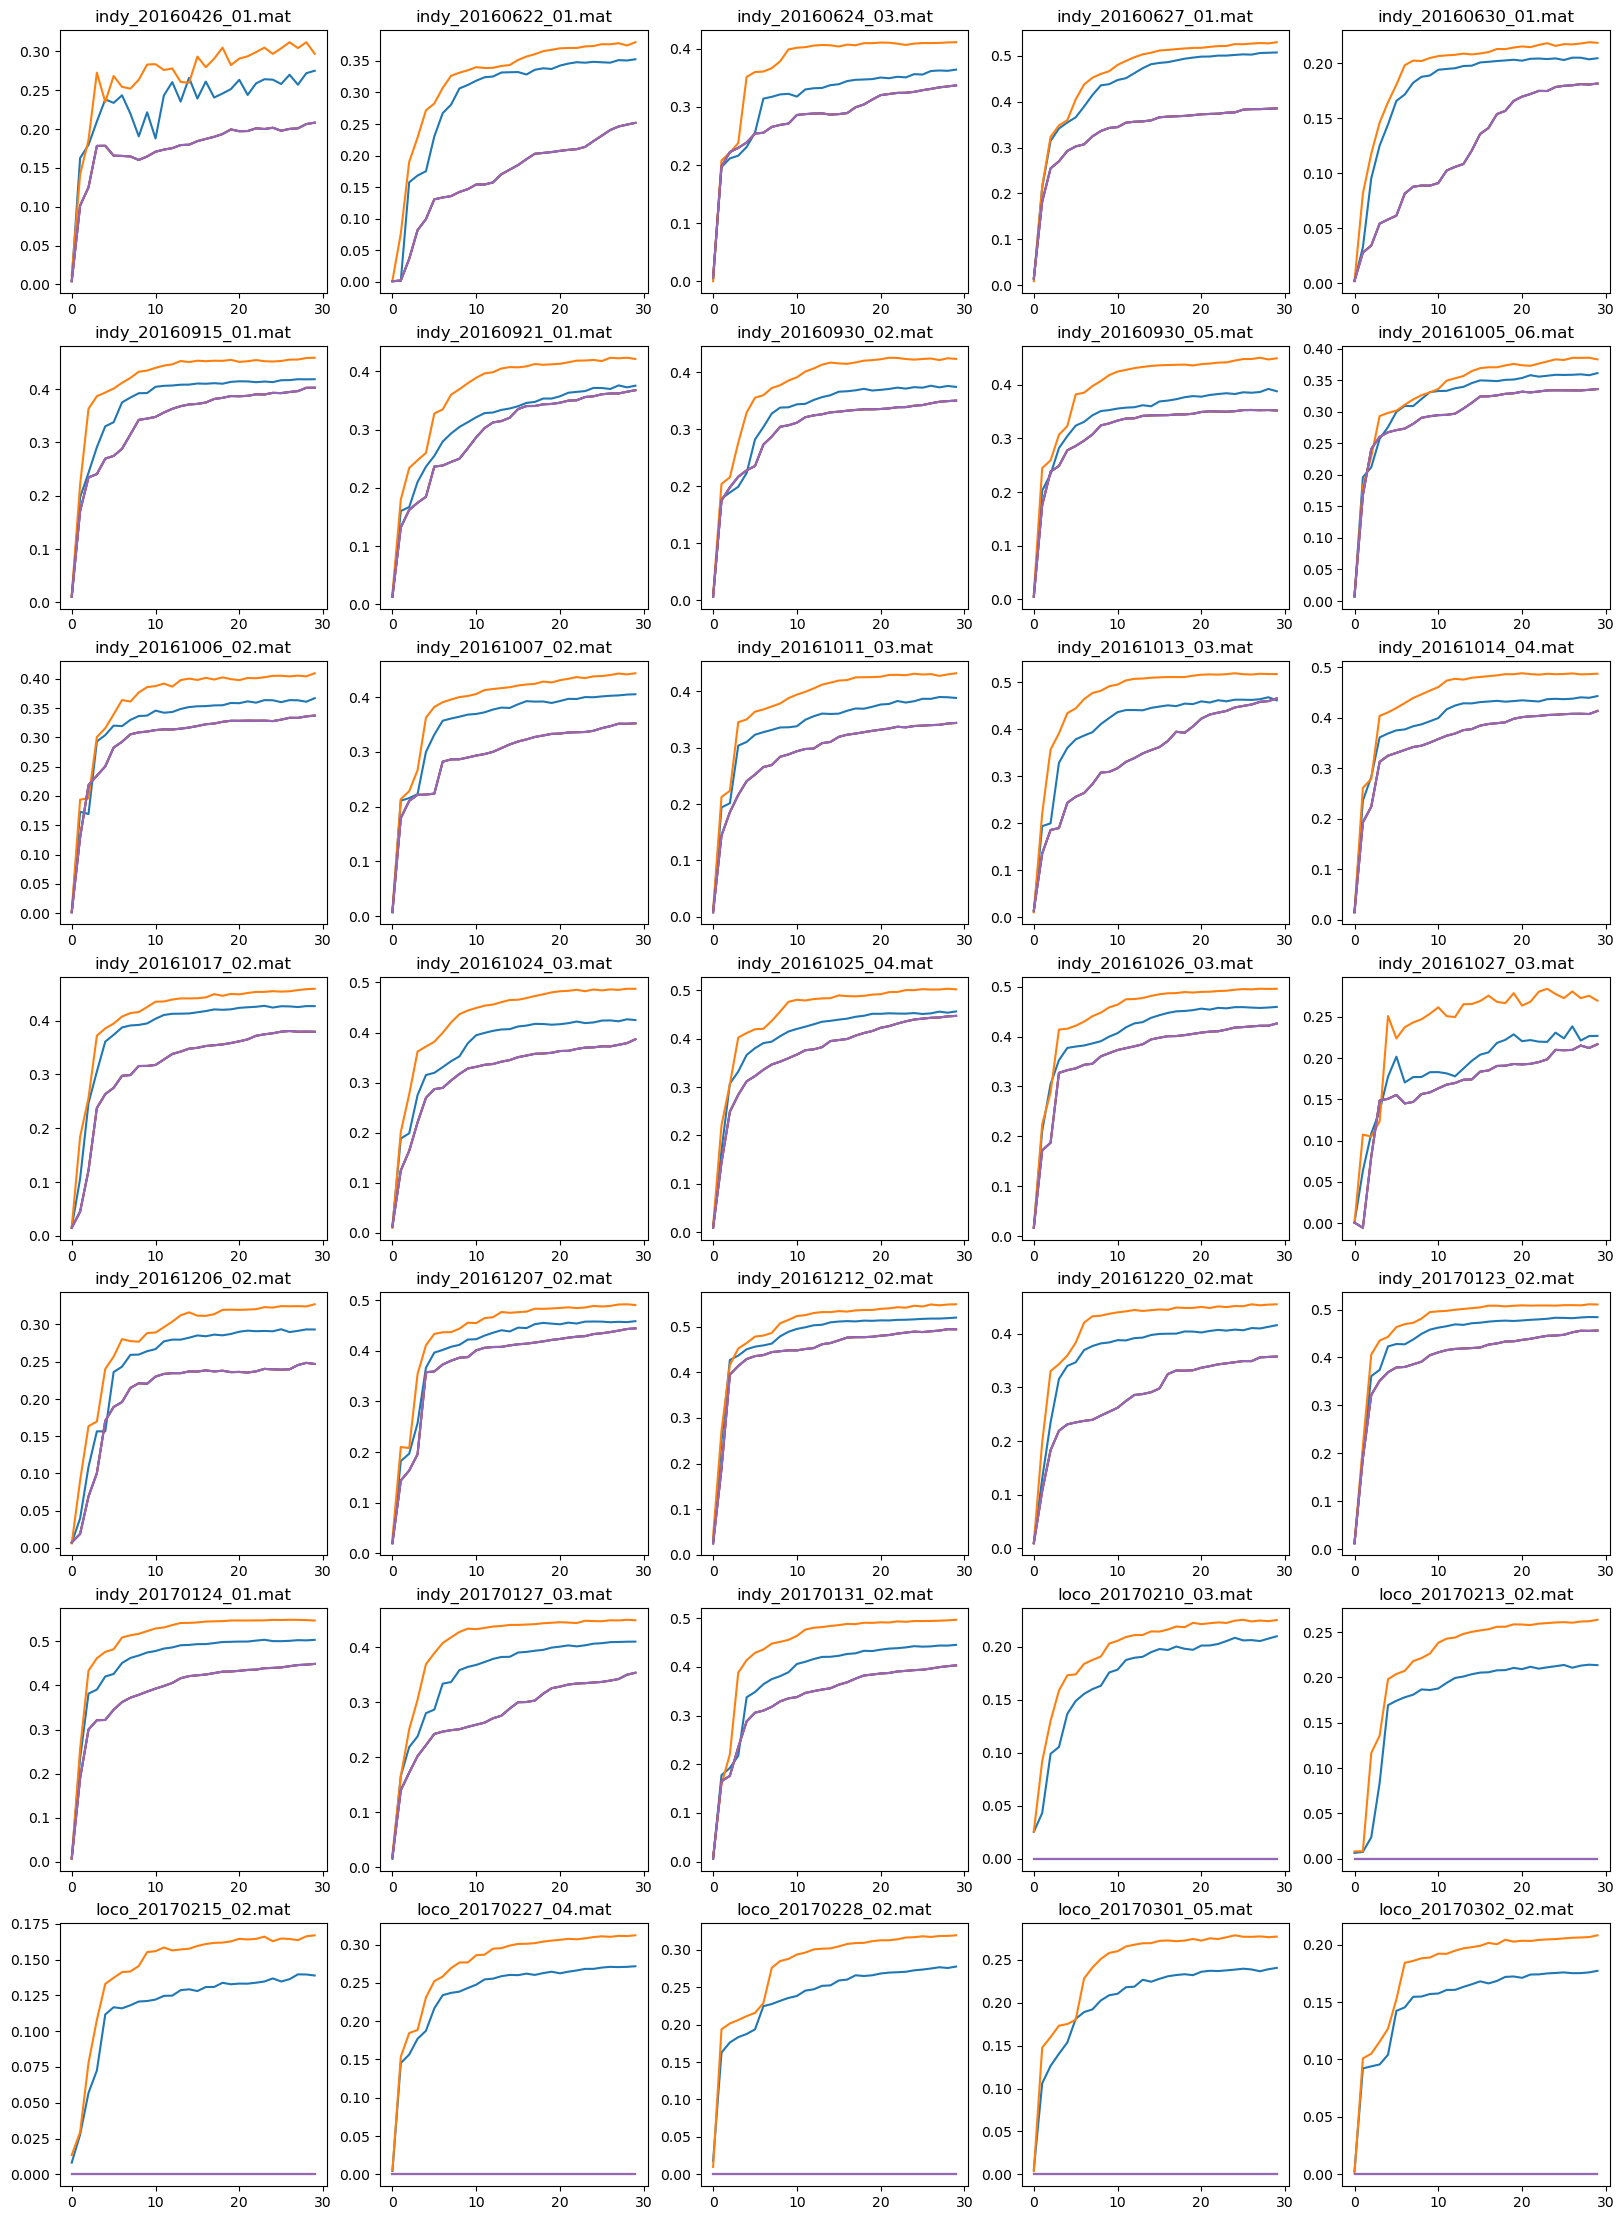

In [13]:
fig, ax = plt.subplots(7, 5, figsize=(20, 28))

for i in range(35):
    a = ax[np.unravel_index(i, (7, 5))]
    a.plot(np.mean(r2, axis=2)[i, :, 1])
    a.plot(np.mean(r2fc, axis=2)[i, :, 1])
    a.plot(np.mean(sr2_vel_pca, axis=2)[i, :])
    a.set_title(data_files[i])

### Z-scored comparison

In [6]:
with open('/home/akumar/nse/neural_control/data/zscored_decoding_df.pkl', 'rb') as f:
    dat = pickle.load(f)
sabes_df = pd.DataFrame(dat)

In [21]:
data_files = np.unique(sabes_df['data_file'].values)
dims = np.unique(sabes_df['dim'].values)

r2p = np.zeros((len(data_files), dims.size, 5, 3))
r2pz = np.zeros((len(data_files), dims.size, 5, 3))

for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):
        for fold_idx in range(5):
            dim_df = apply_df_filters(sabes_df, data_file=data_file, dim=dim, fold_idx=fold_idx, dimreduc_method='PCA')
            assert(dim_df.shape[0] == 2)
            for k in range(2):
                if 'normalize' in dim_df.iloc[k]['dimreduc_args'].keys():
                    r2pz[i, j, fold_idx, :] = dim_df.iloc[0]['r2']
                else:
                    r2p[i, j, fold_idx, :] = dim_df.iloc[0]['r2']

35it [00:07,  4.56it/s]


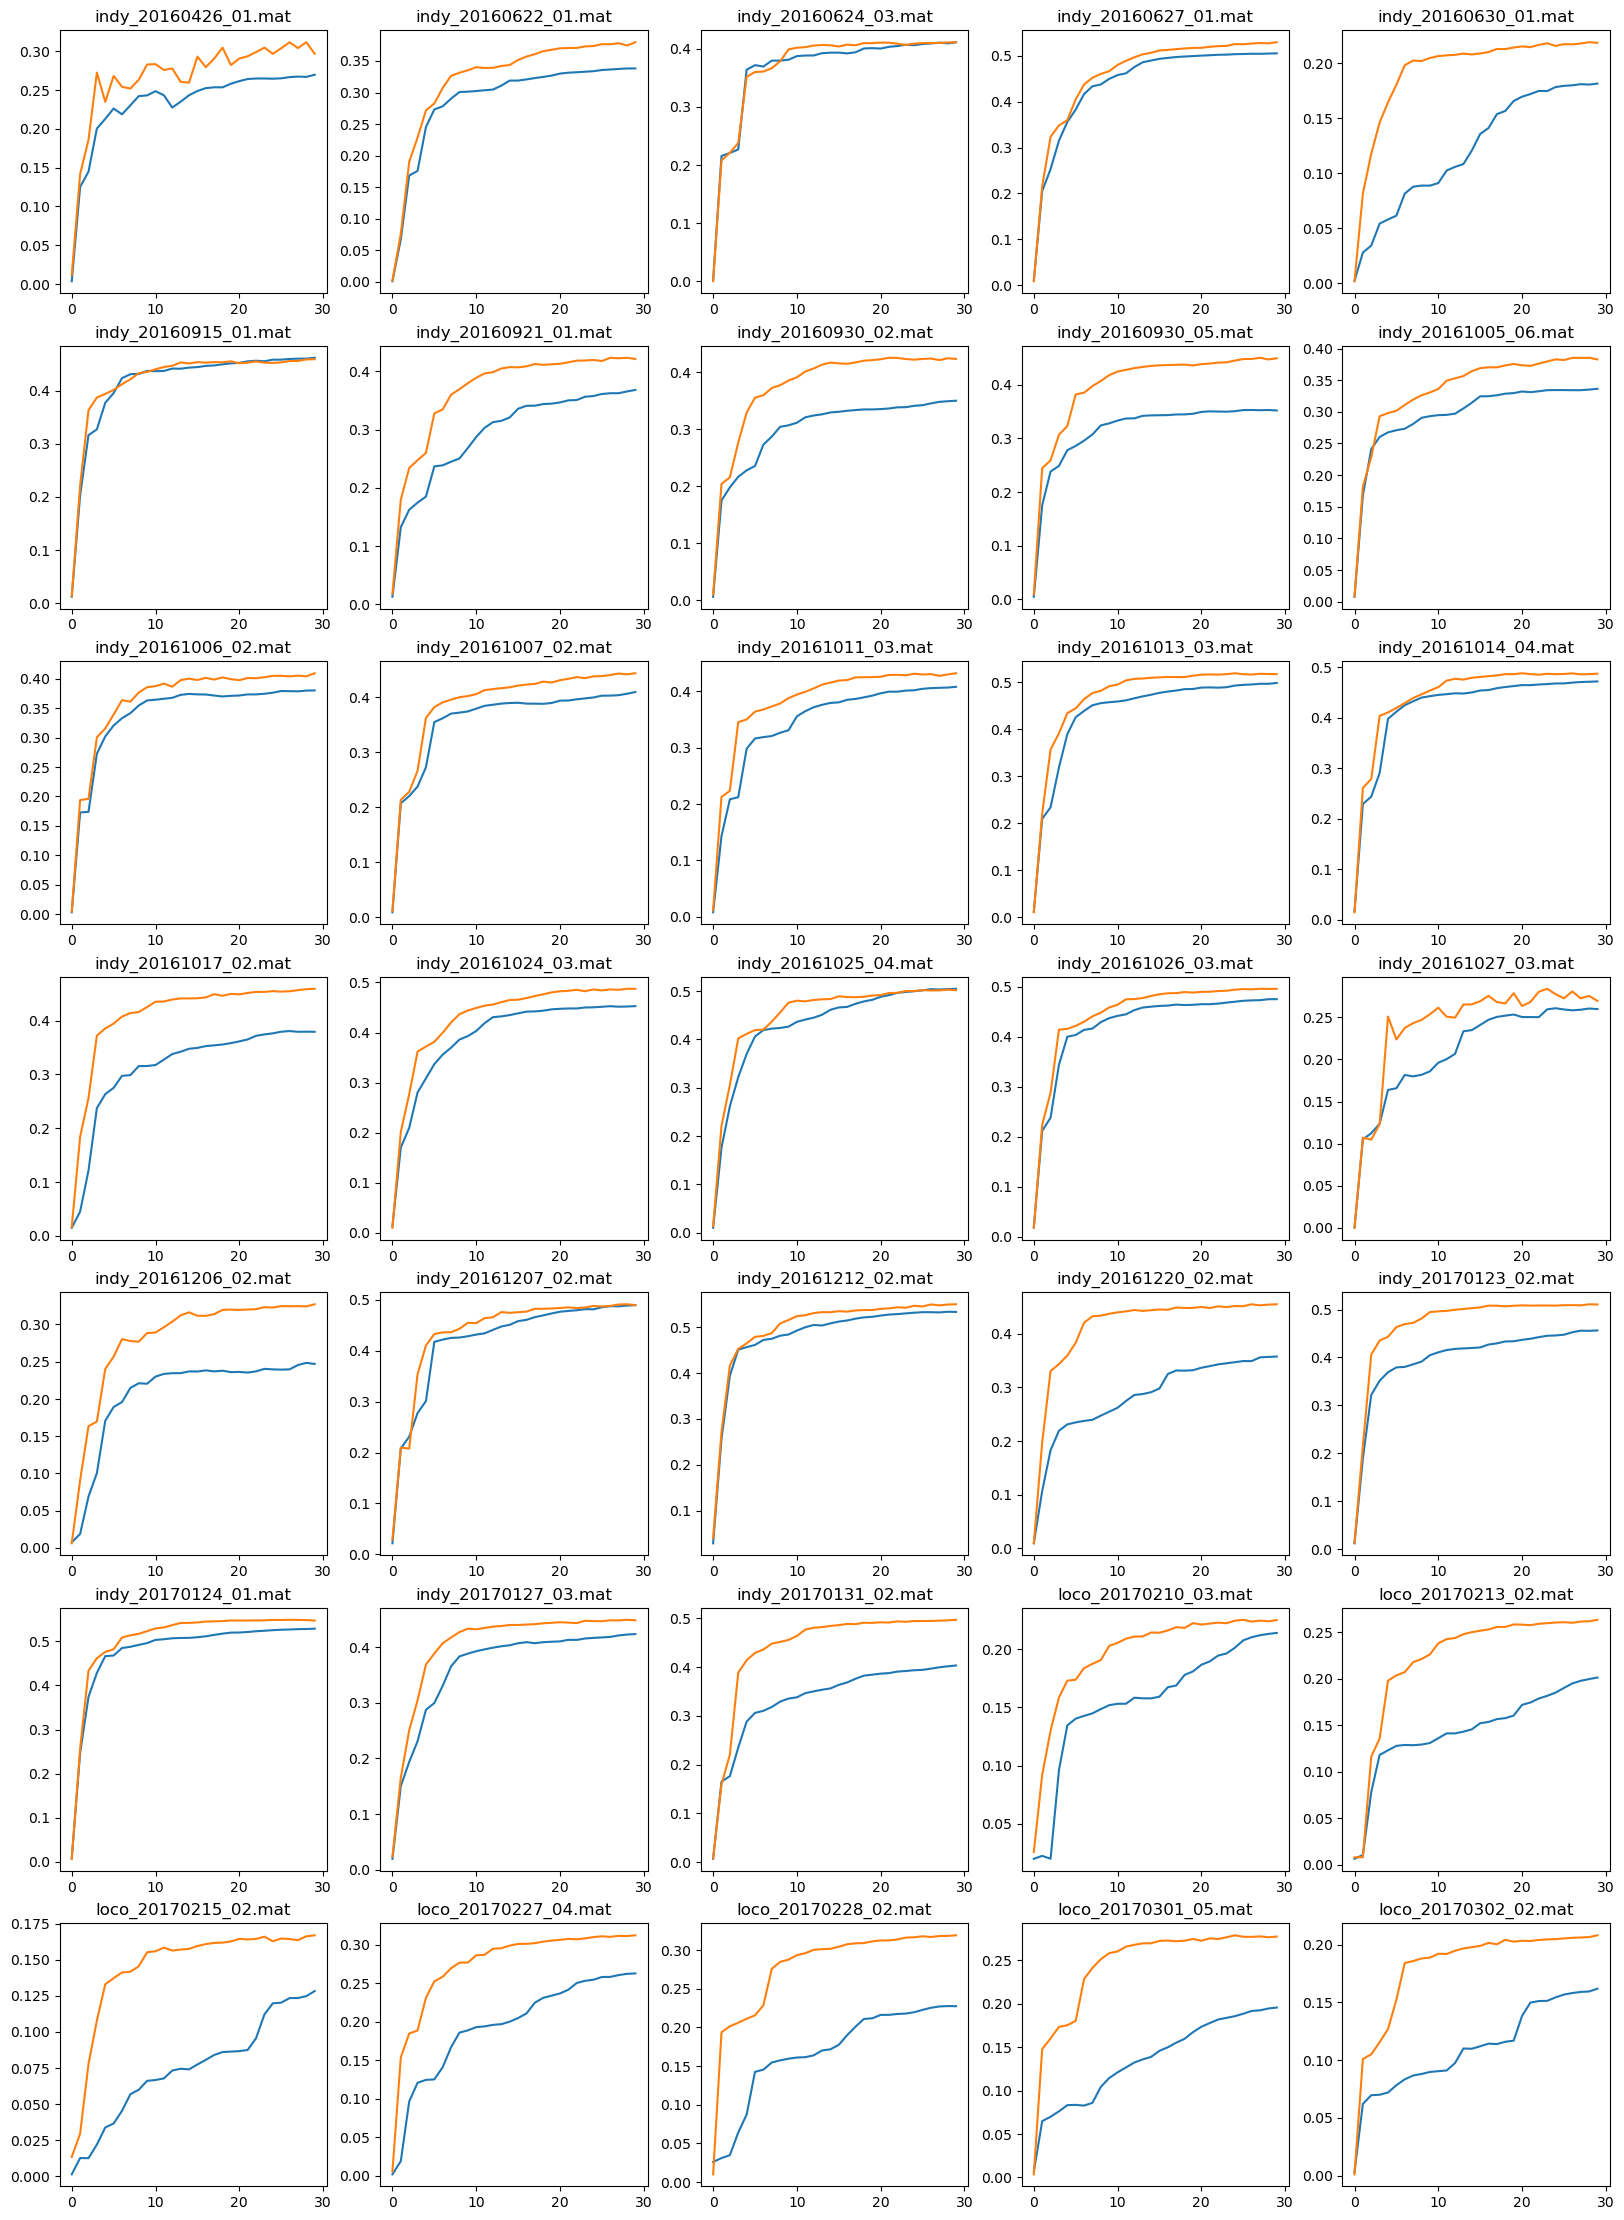

In [33]:
fig, ax = plt.subplots(7, 5, figsize=(20, 28))

for i in range(35):
    a = ax[np.unravel_index(i, (7, 5))]
    # a.plot(np.mean(r2p, axis=2)[i, :, 1])
    a.plot(np.mean(r2pz, axis=2)[i, :, 1])
    #a.plot(np.mean(r2, axis=2)[i, :, 1])
    a.plot(np.mean(r2fc, axis=2)[i, :, 1])
    #a.plot(np.mean(sr2_vel_pca, axis=2)[i, :])

    a.set_title(data_files[i])